In [1]:
!pip install ultralytics opencv-python numpy pandas torch torchvision torchaudio

In [2]:
%matplotlib inline

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from ultralytics import YOLO
import torch
import os
import shutil

In [4]:
# Define paths
fine_tuned_model_path = "saved_models/finetuned_yolov8n.pt"
os.makedirs(os.path.dirname(fine_tuned_model_path), exist_ok=True)

# Check if a fine-tuned model exists
if os.path.exists(fine_tuned_model_path):
    print(f"Loading fine-tuned model from {fine_tuned_model_path}")
    model = YOLO(fine_tuned_model_path)  # Load the fine-tuned model
else:
    print("No fine-tuned model found, initializing YOLOv8 base model.")
    model = YOLO("yolov8n.pt")  # Load pre-trained YOLOv8 model

# Set up training parameters and train the model if no fine-tuned model exists
if not os.path.exists(fine_tuned_model_path):
    # Train the model and get the results object that contains the path information
    results = model.train(
        data="data.yaml",  # Path to dataset configuration file
        epochs=50,  # Number of training epochs
        batch=16,  # Batch size
        imgsz=640,  # Image size
        device="cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
    )
    
    # Extract the actual path to the best model from the results
    if hasattr(results, 'best'):
        trained_model_path = results.best  # Get best model path from results
    else:
        # Fallback to checking the standard YOLOv8 output directory structure
        # Look for any 'train' directory in runs/detect/
        import glob
        train_dirs = sorted(glob.glob("runs/detect/train*/weights/best.pt"))
        if train_dirs:
            trained_model_path = train_dirs[-1]  # Use the most recent one
        else:
            trained_model_path = None

    if trained_model_path and os.path.exists(trained_model_path):
        print(f"Training completed successfully. Saving the fine-tuned model from {trained_model_path}")

        # Load trained model and export it correctly
        model = YOLO(trained_model_path)  # Load the best trained model
        model.export(format="torchscript")  # Convert model to TorchScript format for stability

        # Save the model correctly
        shutil.copy(trained_model_path, fine_tuned_model_path)
        print(f"Fine-tuned model saved at {fine_tuned_model_path}")
    else:
        print("Error: Training did not produce 'best.pt'. Please check training logs.")
else:
    print("Using the pre-saved fine-tuned model.")

Loading fine-tuned model from saved_models/finetuned_yolov8n.pt
Using the pre-saved fine-tuned model.


In [5]:
def detect_vehicles(frame):
    """
    Detect vehicles in a frame using YOLOv8.
    Returns bounding boxes [(x1, y1, x2, y2, class_id, color)].
    """
    results = model(frame)
    vehicles = []
    
    # Define vehicle classes mapping for better readability
    vehicle_classes = {1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle'}
    
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            
            # Filter by confidence threshold
            if confidence < 0.6:  # Adjust threshold as needed
                continue
                
            # Consider only vehicle classes
            if class_id in vehicle_classes:
                color = get_vehicle_color(frame, (x1, y1, x2, y2))  # Extract vehicle color
                vehicles.append((x1, y1, x2, y2, class_id, color))  # Return 6 values
    
    print(f"\n🟢 [DETECTION] Vehicles Detected: {len(vehicles)}")
    return vehicles


In [6]:
def get_vehicle_color(frame, bbox):
    """
    Extracts the dominant color from the vehicle bounding box.
    Returns the mean (R, G, B) color with robustness to shadows and highlights.
    """
    x1, y1, x2, y2 = map(int, bbox)
    vehicle_roi = frame[y1:y2, x1:x2]
    
    if vehicle_roi.size == 0:  # Prevent errors with empty ROIs
        return (0, 0, 0)
    
    # Remove shadows/highlights by excluding very dark and very bright pixels
    mask = cv2.inRange(vehicle_roi, np.array([20, 20, 20]), np.array([235, 235, 235]))
    masked_roi = cv2.bitwise_and(vehicle_roi, vehicle_roi, mask=mask)
    
    if cv2.countNonZero(mask) == 0:  # If mask removed all pixels
        mean_color = cv2.mean(vehicle_roi)[:3]  # Fall back to original method
    else:
        mean_color = cv2.mean(masked_roi, mask=mask)[:3]
        
    # OpenCV uses BGR, convert to RGB
    return (int(mean_color[2]), int(mean_color[1]), int(mean_color[0]))

In [38]:
class VehicleTracker:
    """
    Tracks vehicles using type, color, centroid distance, and motion.
    Vehicles are stored separately by their class_id.
    """
    def __init__(self):
        # Structure: {class_id: {vehicle_id: (last_frame, last_centroid, direction, color, trajectory)}}
        self.vehicles = {}
        self.next_vehicle_id = 1  # Unique ID counter
        # Define vehicle class names for visualization
        self.class_names = {1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle'}
        # Define colors for visualization
        self.incoming_color = (0, 255, 0)  # Green for incoming
        self.outgoing_color = (0, 0, 255)  # Red for outgoing
        
    def update(self, detected_vehicles, frame_idx, frame, fps):
        """
        Updates the tracker with new detections.
        Performs one-to-one matching within each class based on a combined cost (distance + color_diff)
        under the conditions:
          - Euclidean distance < 50 pixels,
          - Color difference < 50,
          - Time difference (frame_idx - last_frame) <= 3.
        Returns:
          - new_vehicles: list of (vehicle_id, direction) for newly added vehicles,
          - old_vehicles: list of (vehicle_id, direction) for updated vehicles,
          - frame_with_boxes: the frame with drawn bounding boxes and labels.
        """
        print(f"🔵 [FRAME {frame_idx}] Vehicles Detected: {len(detected_vehicles)}")
        
        new_vehicles_list = []
        old_vehicles_list = []
        frame_with_boxes = frame.copy()

        # Group new detections by class_id
        new_detections_by_class = {}
        for det in detected_vehicles:
            x1, y1, x2, y2, class_id, color = det
            new_detections_by_class.setdefault(class_id, []).append(det)

        # Process matching for each class separately
        for class_id, new_detections in new_detections_by_class.items():
            # If there are no existing vehicles of this class, initialize empty dictionary.
            if class_id not in self.vehicles:
                self.vehicles[class_id] = {}

            # Prepare candidate matches using vectorized operations
            existing_vehicles = self.vehicles[class_id]
            if not existing_vehicles:
                # No existing vehicles to match, all new detections will be new vehicles
                new_centroids = [((det[0] + det[2]) / 2, (det[1] + det[3]) / 2) for det in new_detections]
                new_colors = [det[5] for det in new_detections]
                
                for i, (detection, centroid_new, color_new) in enumerate(zip(new_detections, new_centroids, new_colors)):
                    x1, y1, x2, y2, _, _ = detection
                    # Set initial direction based on frame height midpoint.
                    direction = "Incoming" if centroid_new[1] > frame.shape[0] / 2 else "Outgoing"
                    vid = self.next_vehicle_id
                    self.next_vehicle_id += 1
                    # Initialize trajectory with current centroid
                    self.vehicles.setdefault(class_id, {})[vid] = (
                        frame_idx, centroid_new, direction, color_new, [centroid_new]
                    )
                    new_vehicles_list.append((vid, direction))
                    
                    # Draw bounding box and label for new vehicle
                    box_color = self.incoming_color if direction == "Incoming" else self.outgoing_color
                    cv2.rectangle(frame_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), box_color, 2)
                    
                    # Add class name and ID to label
                    class_name = self.class_names.get(class_id, "vehicle")
                    label = f"{class_name} {vid} ({direction})"
                    cv2.putText(frame_with_boxes, label, (int(x1), int(y1) - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)
                continue
                
            # Prepare list of candidate matches (cost, new_idx, existing_vehicle_id)
            candidate_matches = []
            # We'll keep track of which new detection (index) and which existing vehicle (id) get matched.
            new_assigned = {}
            existing_assigned = set()

            # Compute all potential matches in a more vectorized way
            for new_idx, detection in enumerate(new_detections):
                x1, y1, x2, y2, _, color_new = detection
                centroid_new = ((x1 + x2) / 2, (y1 + y2) / 2)

                for vid, (last_frame, last_centroid, _, color_existing, _) in existing_vehicles.items():
                    # Check time consistency: update only if within 3 frames
                    if frame_idx - last_frame > fps * 3:
                        continue

                    # Compute Euclidean distance and color difference
                    distance = np.sqrt((centroid_new[0] - last_centroid[0])**2 + (centroid_new[1] - last_centroid[1])**2)
                    color_diff = np.linalg.norm(np.array(color_new) - np.array(color_existing))

                    # Check if within thresholds
                    if distance < 50 and color_diff < 75:
                        cost = distance + color_diff
                        candidate_matches.append((cost, new_idx, vid))
            
            # Sort candidate matches by cost (greedy lowest cost first)
            candidate_matches.sort(key=lambda x: x[0])

            # Assign matches greedily ensuring one-to-one mapping
            for cost, new_idx, vid in candidate_matches:
                if new_idx in new_assigned or vid in existing_assigned:
                    continue  # already assigned
                new_assigned[new_idx] = vid
                existing_assigned.add(vid)

            # Process matched and unmatched detections
            for new_idx, detection in enumerate(new_detections):
                x1, y1, x2, y2, _, color_new = detection
                centroid_new = ((x1 + x2) / 2, (y1 + y2) / 2)
                
                if new_idx in new_assigned:
                    # Update existing vehicle
                    vid = new_assigned[new_idx]
                    last_frame, last_centroid, last_direction, _, trajectory = existing_vehicles[vid]
                    
                    # Update trajectory with new centroid (keep last 5 points for efficiency)
                    trajectory.append(centroid_new)
                    if len(trajectory) > 5:
                        trajectory = trajectory[-5:]
                    
                    # Determine direction using trajectory history
                    if len(trajectory) >= 2:
                        # Calculate average vertical movement over trajectory
                        vertical_moves = [trajectory[i+1][1] - trajectory[i][1] for i in range(len(trajectory)-1)]
                        avg_vertical_move = sum(vertical_moves) / len(vertical_moves)
                        new_direction = "Incoming" if avg_vertical_move > 0 else "Outgoing"
                    else:
                        # Fallback to simple comparison if trajectory is too short
                        new_direction = "Incoming" if centroid_new[1] > last_centroid[1] else "Outgoing"
                    
                    # Simple motion smoothing (basic Kalman-like filtering)
                    smoothed_centroid = (
                        0.7 * centroid_new[0] + 0.3 * last_centroid[0],
                        0.7 * centroid_new[1] + 0.3 * last_centroid[1]
                    )
                    
                    # Update vehicle record
                    existing_vehicles[vid] = (frame_idx, smoothed_centroid, new_direction, color_new, trajectory)
                    old_vehicles_list.append((vid, new_direction))
                    
                    # Draw bounding box and label for updated vehicle
                    box_color = self.incoming_color if new_direction == "Incoming" else self.outgoing_color
                    cv2.rectangle(frame_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), box_color, 2)
                    
                    # Add class name and ID to label
                    class_name = self.class_names.get(class_id, "vehicle")
                    label = f"{class_name} {vid} ({new_direction})"
                    cv2.putText(frame_with_boxes, label, (int(x1), int(y1) - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)
                    
                    # Draw trajectory
                    if len(trajectory) >= 2:
                        for i in range(len(trajectory) - 1):
                            p1 = (int(trajectory[i][0]), int(trajectory[i][1]))
                            p2 = (int(trajectory[i+1][0]), int(trajectory[i+1][1]))
                            cv2.line(frame_with_boxes, p1, p2, box_color, 2)
                else:
                    # Create new vehicle entry
                    direction = "Incoming" if centroid_new[1] > frame.shape[0] / 2 else "Outgoing"
                    vid = self.next_vehicle_id
                    self.next_vehicle_id += 1
                    # Initialize trajectory with current centroid
                    existing_vehicles[vid] = (frame_idx, centroid_new, direction, color_new, [centroid_new])
                    new_vehicles_list.append((vid, direction))
                    
                    # Draw bounding box and label for new vehicle
                    box_color = self.incoming_color if direction == "Incoming" else self.outgoing_color
                    cv2.rectangle(frame_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), box_color, 2)
                    
                    # Add class name and ID to label
                    class_name = self.class_names.get(class_id, "vehicle")
                    label = f"{class_name} {vid} ({direction})"
                    cv2.putText(frame_with_boxes, label, (int(x1), int(y1) - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)

        return new_vehicles_list, old_vehicles_list, frame_with_boxes

In [39]:
def process_video(input_video_path, output_video_path, output_csv_path, start_time_sec, end_time_sec):
    """
    Process a video, track unique vehicles in the given time range,
    classify them as Incoming or Outgoing, and save results.
    Only one frame per second is processed for detection/tracking.
    """
    cap = cv2.VideoCapture(input_video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_duration = frame_count / fps  # Total video duration in seconds

    # Convert input times to frame indices
    start_frame = int(start_time_sec * fps)
    end_frame = int(end_time_sec * fps)

    if end_time_sec > total_duration:
        print("\n⚠ [WARNING] End time exceeds video duration! Using last frame instead.")
        end_frame = frame_count - 1

    # Initialize vehicle tracker
    tracker = VehicleTracker()

    # Set up video writer for output
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_idx > end_frame:
            break

        # Only process frames in the selected interval
        if frame_idx < start_frame:
            frame_idx += 1
            continue

        # Process only one frame per second
        if frame_idx % fps == 0:
            # Detect vehicles in the frame
            vehicles = detect_vehicles(frame)

            # Update tracker with detected vehicles
            new_vehicles, old_vehicles, frame_with_boxes = tracker.update(vehicles, frame_idx, frame, fps)

            # Print debug statements only for processed frames (every second)
            second_elapsed = frame_idx // fps
            print("\n🟠 [TIME UPDATE] -------------------------------------")
            print(f"🕒 Time Elapsed: {second_elapsed} sec")
            print(f"📊 Vehicles Detected: {len(vehicles)} in this second")
            print("🚗 New Vehicles:")
            for vid, direction in new_vehicles:
                print(f"    - Vehicle {vid}: {direction}")
            print("🚙 Old Vehicles:")
            for vid, direction in old_vehicles:
                print(f"    - Vehicle {vid}: {direction}")
            print("--------------------------------------------------")

            # Display the processed frame using Matplotlib
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_idx} - Time: {second_elapsed} sec")
            plt.axis('off')
            plt.show()

            out.write(frame_with_boxes)  # Save the processed frame
        else:
            # For frames not processed, you can write the original frame or simply skip writing.
            # Here, we write the original frame to maintain video length.
            out.write(frame)

        frame_idx += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()  # Close all OpenCV windows after processing

    # Final results: iterate through each class's vehicles
    incoming_count = sum(
        1 for class_dict in tracker.vehicles.values()
          for vehicle in class_dict.values() if vehicle[2] == "Incoming"
    )
    outgoing_count = sum(
        1 for class_dict in tracker.vehicles.values()
          for vehicle in class_dict.values() if vehicle[2] == "Outgoing"
    )
    
    result = {
        "Incoming Vehicles": incoming_count,
        "Outgoing Vehicles": outgoing_count
    }

    # Save results to CSV
    pd.DataFrame([result]).to_csv(output_csv_path, index=False)

    print("\n✅ [PROCESS COMPLETE] -----------------------------------")
    print(f"📌 Processed Video Interval: {start_time_sec} - {end_time_sec} sec")
    print(f"📂 Vehicle Counts Saved to: {output_csv_path}")
    print(f"🚗 Incoming Vehicles: {result['Incoming Vehicles']}")
    print(f"🚙 Outgoing Vehicles: {result['Outgoing Vehicles']}")
    print("---------------------------------------------------------")


0: 480x640 1 car, 79.3ms
Speed: 2.6ms preprocess, 79.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 100] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 10 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
    - Vehicle 1: Incoming
🚙 Old Vehicles:
--------------------------------------------------


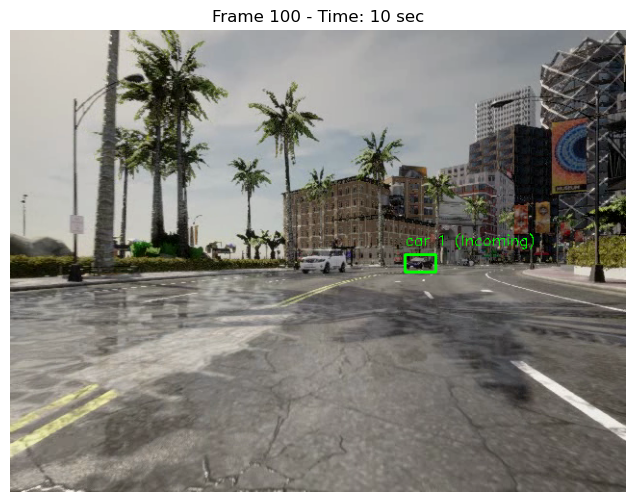


0: 480x640 2 cars, 60.6ms
Speed: 1.8ms preprocess, 60.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 0
🔵 [FRAME 110] Vehicles Detected: 0

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 11 sec
📊 Vehicles Detected: 0 in this second
🚗 New Vehicles:
🚙 Old Vehicles:
--------------------------------------------------


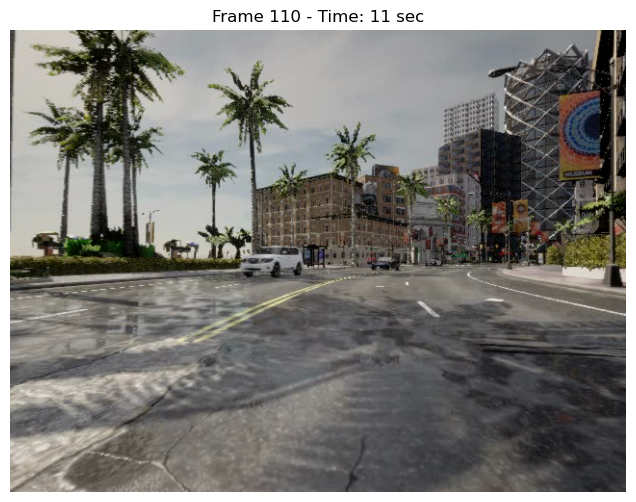


0: 480x640 3 cars, 74.3ms
Speed: 1.2ms preprocess, 74.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 120] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 12 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
    - Vehicle 2: Outgoing
🚙 Old Vehicles:
--------------------------------------------------


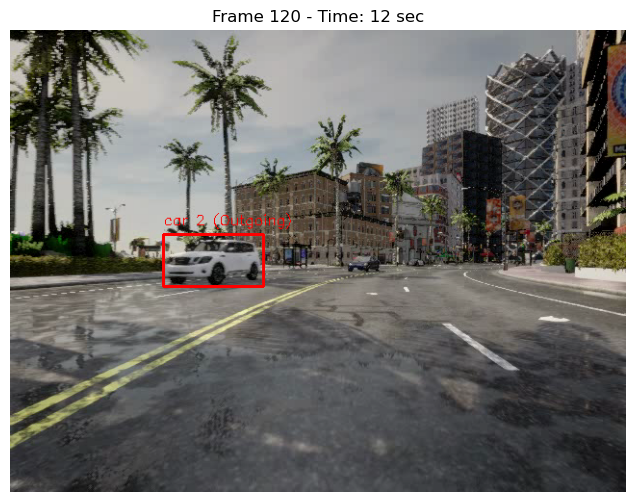


0: 480x640 3 cars, 78.3ms
Speed: 1.2ms preprocess, 78.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 2
🔵 [FRAME 130] Vehicles Detected: 2

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 13 sec
📊 Vehicles Detected: 2 in this second
🚗 New Vehicles:
    - Vehicle 3: Incoming
    - Vehicle 4: Incoming
🚙 Old Vehicles:
--------------------------------------------------


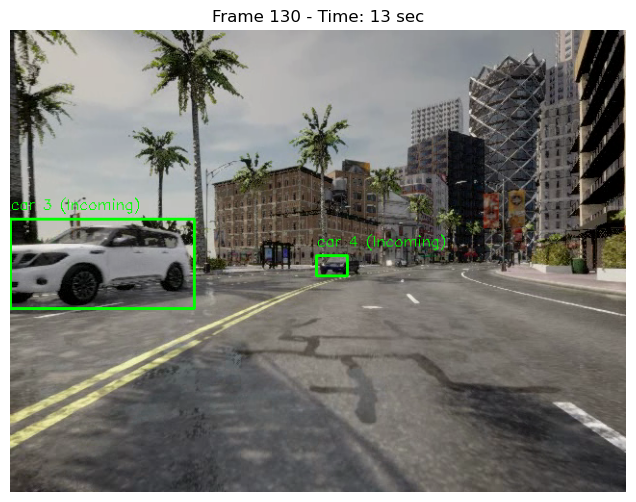


0: 480x640 2 randoms, 1 car, 135.1ms
Speed: 1.1ms preprocess, 135.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 140] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 14 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
🚙 Old Vehicles:
    - Vehicle 4: Incoming
--------------------------------------------------


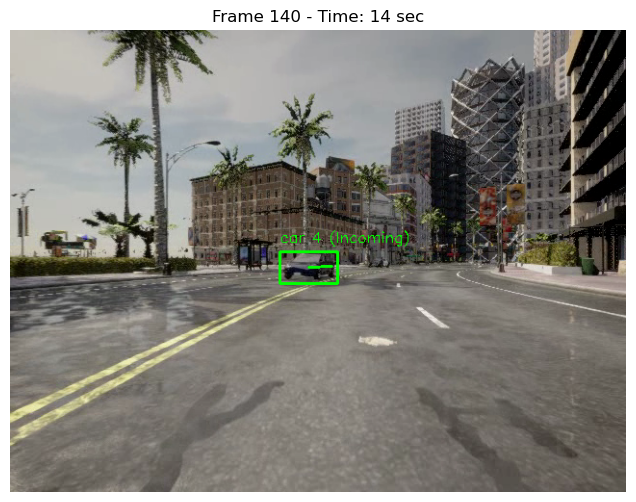


0: 480x640 1 random, 2 cars, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 150] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 15 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
🚙 Old Vehicles:
    - Vehicle 4: Incoming
--------------------------------------------------


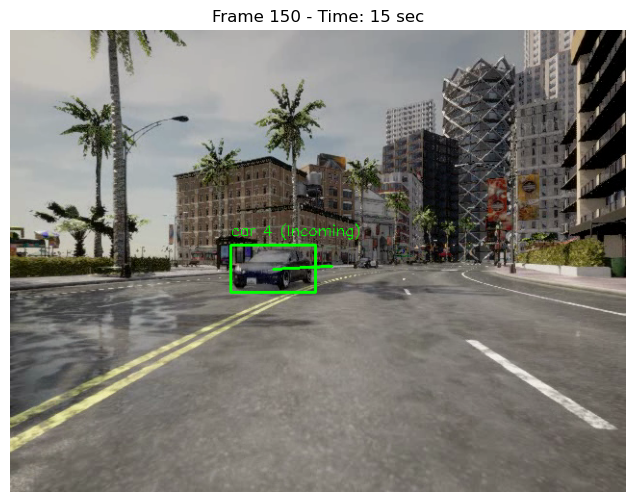


0: 480x640 3 cars, 55.7ms
Speed: 1.2ms preprocess, 55.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 2
🔵 [FRAME 160] Vehicles Detected: 2

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 16 sec
📊 Vehicles Detected: 2 in this second
🚗 New Vehicles:
    - Vehicle 5: Incoming
    - Vehicle 6: Incoming
🚙 Old Vehicles:
--------------------------------------------------


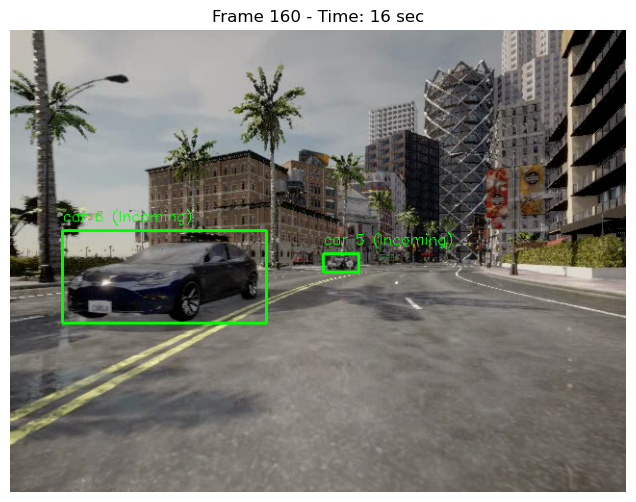


0: 480x640 2 cars, 52.9ms
Speed: 1.0ms preprocess, 52.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 170] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 17 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
🚙 Old Vehicles:
    - Vehicle 5: Incoming
--------------------------------------------------


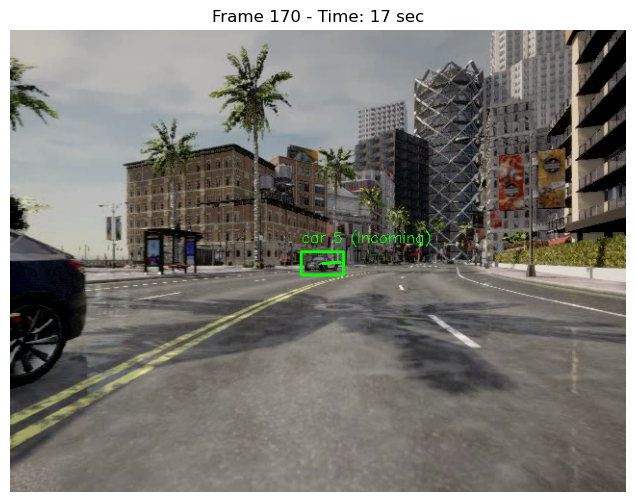


0: 480x640 2 cars, 60.3ms
Speed: 0.9ms preprocess, 60.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 180] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 18 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
🚙 Old Vehicles:
    - Vehicle 4: Outgoing
--------------------------------------------------


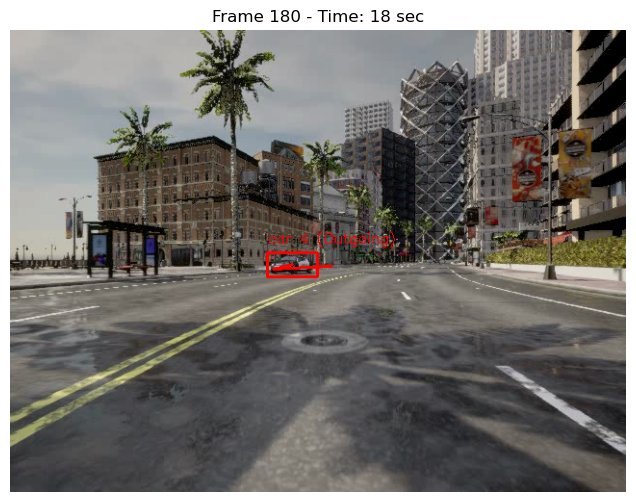


0: 480x640 1 car, 53.7ms
Speed: 1.2ms preprocess, 53.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 190] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 19 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
🚙 Old Vehicles:
    - Vehicle 4: Incoming
--------------------------------------------------


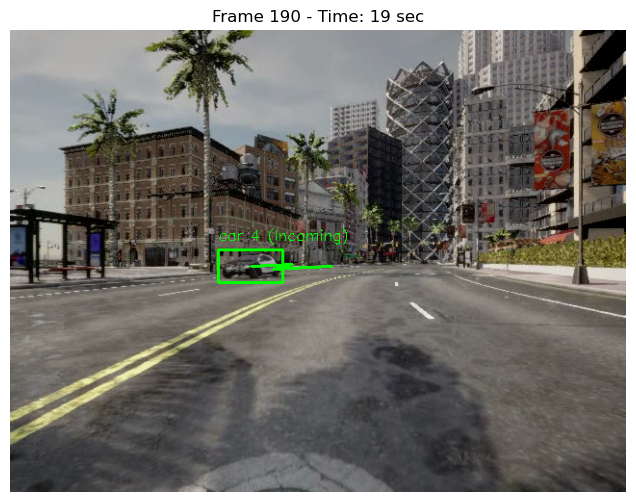


0: 480x640 1 car, 64.1ms
Speed: 1.1ms preprocess, 64.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

🟢 [DETECTION] Vehicles Detected: 1
🔵 [FRAME 200] Vehicles Detected: 1

🟠 [TIME UPDATE] -------------------------------------
🕒 Time Elapsed: 20 sec
📊 Vehicles Detected: 1 in this second
🚗 New Vehicles:
    - Vehicle 7: Incoming
🚙 Old Vehicles:
--------------------------------------------------


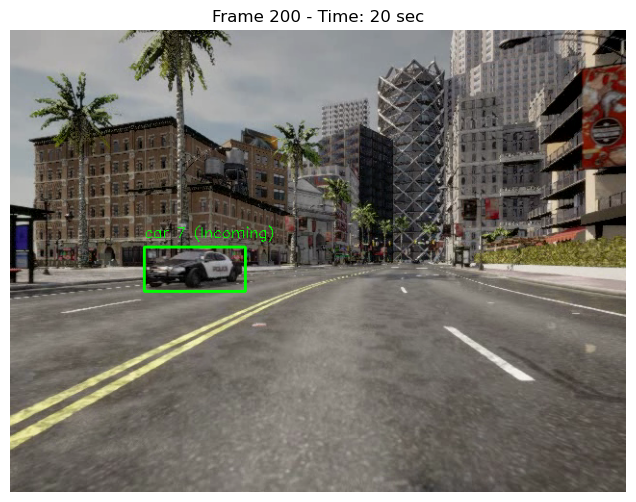


✅ [PROCESS COMPLETE] -----------------------------------
📌 Processed Video Interval: 10 - 20 sec
📂 Vehicle Counts Saved to: ./result/vehicle_counts.csv
🚗 Incoming Vehicles: 6
🚙 Outgoing Vehicles: 1
---------------------------------------------------------


In [41]:
input_video = "./frames/output739864687.mp4"
output_video = "./result/output_lane_detected.mp4"
output_csv = "./result/vehicle_counts.csv"

# Define the time range (e.g., analyze vehicles from 10s to 30s)
start_time_sec = 10
end_time_sec = 20

process_video(input_video, output_video, output_csv, start_time_sec, end_time_sec)